# Example 1: Detecting vocalizations from a WAV File

In this notebook we will

* Load an audio file

* Compute amplitude envelope

* Detect vocal periods by thresholding on the amplitude envelope

* Split up vocal periods into (putative) individual calls

In [1]:
import sys
sys.path.append("../code/soundsep")

In [2]:
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Audio, display
from soundsig.sound import plot_spectrogram, spectrogram
from soundsig.signal import bandpass_filter

from audio_utils import get_amplitude_envelope, interval_idx2time
from detection.thresholding import (
    compute_smart_threshold,
    split_individual_events,
    threshold_all_events,
    threshold_events
)
from interfaces.audio import LazyWavInterface
from plotting_utils import MultiChannelPlotter, MultiSpecPlotter

%load_ext autoreload
%autoreload 2

## 1. Load the data

Audio signals can be loaded in multiple ways, found in `interfaces.audio`.

The most basic way is to use a numpy array in `interfaces.audio.NumpyDataInterface`. However, for large datasets it's sometimes faster/easier/less-memory-intensive to use lazy loading, which doesn't read data into memory until requested. To do this directly from a .wav file on disk, we can use `interfaces.audio.LazyWavInterface`.

In [3]:
audio_signal = LazyWavInterface("example.wav", dtype=np.float64)

Here is an example of loading the first 60 seconds of data

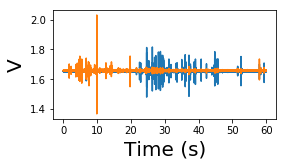

In [4]:
t_arr, data = audio_signal.time_slice(t_start=0.0, t_stop=60.0)
fig = plt.figure(figsize=(4, 2))
plt.plot(t_arr, data)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("V", fontsize=20)
plt.show()
plt.close(fig)

## 2. Compute an amplitude envelope

To detect vocalizations based on the amplitude envelope, we need to compute the amplitude envelope using `audio_utils.get_amplitude_envelope`.

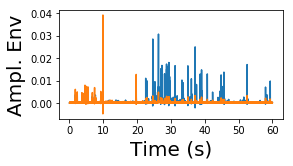

In [5]:
t_arr, data = audio_signal.time_slice(t_start=0.0, t_stop=60.0)
amp_env = get_amplitude_envelope(data, fs=audio_signal.sampling_rate)
fig = plt.figure(figsize=(4, 2))
plt.plot(t_arr, amp_env)
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("Ampl. Env", fontsize=20)
plt.show()
plt.close(fig)

For convenience, I'll use the custom `plotting_utils.MultiChannelPlotter` class and `plotting_utils.MultiSpecPlotter` to plot the data from multiple channels. Here is a brief example of its usage, but you can use regular plotting functions as well.

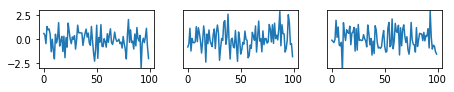

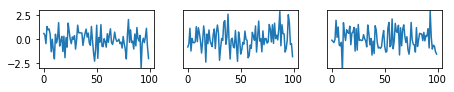

In [6]:
example_data = np.random.normal(size=(3, 100))
plotter = MultiChannelPlotter(example_data, panel_size=(2, 1))
plotter.set_plot_fn(lambda x, ax: ax.plot(x))
plotter.map_axes(lambda ax: ax.set_ylim(-3, 3))
plotter.map_axes(lambda ax: ax.set_yticks([]), select=slice(1, None))
plotter.plot()

## 3. Compute a threshold in a single window to extract potential vocalization periods

For this exercise, I will only use the first channel for thresholding. Potential vocalizations periods are highlighted in pink.

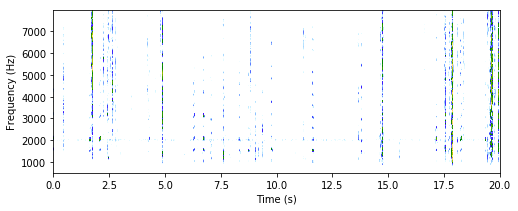

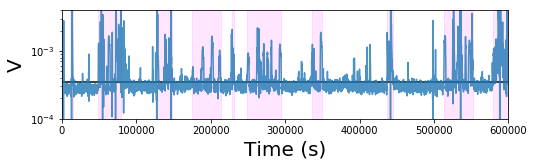

In [7]:
t_arr, data = audio_signal.time_slice(5.0, 25.0)

# First plot the spectrogram of the raw audio
sig = data
sig = sig - np.mean(sig, axis=0)
sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
t_spec, f_spec, spec, _ = spectrogram(
    sig[:, 0],
    audio_signal.sampling_rate,
    1000,
    50,
    min_freq=500,
    max_freq=8000,
    cmplx=False
)
fig = plt.figure(figsize=(8, 3))
plot_spectrogram(t_spec, f_spec, spec, ax=plt.gca(), dBNoise=40, colorbar=False)
plt.show()
plt.close(fig)

# Compute a amplitude envelope and compute threshold
amp_env = get_amplitude_envelope(data, fs=audio_signal.sampling_rate,
                                lowpass=8000, highpass=1000)
threshold = compute_smart_threshold(
    amp_env[:, 0], sampling_rate=audio_signal.sampling_rate, z=1)

intervals = threshold_events(
    amp_env[:, 0],
    threshold,
    sampling_rate=audio_signal.sampling_rate,
    ignore_width=0.05,
    min_size=0.05,
    fuse_duration=0.5
)

fig = plt.figure(figsize=(8, 2))
plt.plot(amp_env[:, 0], alpha=0.8)
plt.hlines(threshold, *plt.xlim())
plt.xlabel("Time (s)", fontsize=20)
plt.yscale("log")
plt.ylim(0.0001, 0.004)
for x, y in intervals:
    plt.fill_between([x, y], *plt.ylim(), color="Magenta", alpha=0.1, zorder=-1)
plt.ylabel("V", fontsize=20)
plt.xlim(0, len(amp_env))
plt.show()
plt.close(fig)

### Here are the spectrograms of just the extracted sound periods

Hit enter to walk through them.

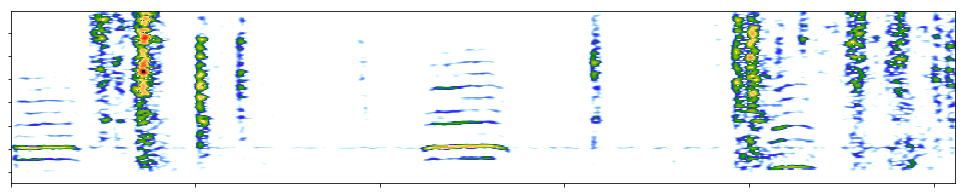

Next (2/10)?exit


In [8]:
for idx, (x, y) in enumerate(intervals):
    t_spec, f_spec, spec, _ = spectrogram(
        sig[x:y, 0],
        audio_signal.sampling_rate,
        1000,
        50,
        min_freq=500,
        max_freq=8000,
        cmplx=False
    )
    width = ((y - x) / audio_signal.sampling_rate) * 16
    plotter = MultiSpecPlotter(
        [[t_spec, f_spec, spec]],
        panel_size=(width, 3),
        layout="vertical",
        colorbar=False,
        dBNoise=30,
    )
    plotter.plot()
    
    quit = input("Next ({}/{})?".format(idx + 1, len(intervals)))
    if quit:
        break
    clear_output(wait=True)

## 4. Secondary thresholding to separate vocalization periods into individual calls

The thresholding in step 3 selects periods that seem like they have vocalizations, but errs on the side of triggering more often than not (this is adjusted with the keyword arguments to `threshold_events`.

Within those intervals selected above, we want to split them up into multiple, individual calls by selecting a second threshold that is much higher than the baseline threshold.

















Skipped interval (12985, 15126); too close to edge of loaded signal


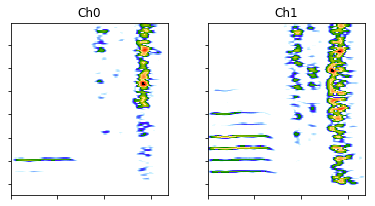

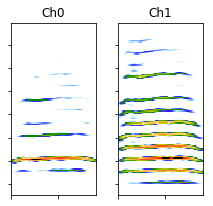

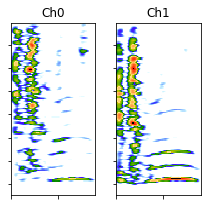

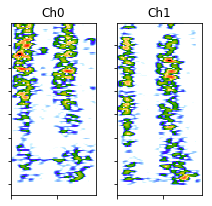

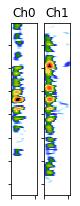

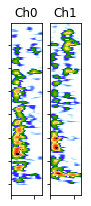

Next (2/10)?exit


In [9]:
for idx, (x, y) in enumerate(intervals):
    # Lets only look at intervals that are not within 1 second
    # from the edge of sig.
    offset = int(audio_signal.sampling_rate)
    if x < offset or y > (len(sig) - offset):
        print("Skipped interval {}; too close to edge of loaded signal".format((x, y)))
        continue
    
    inner_intervals = split_individual_events(
        sig[x - offset:y + offset, 0],
        audio_signal.sampling_rate,
        expected_call_max_duration=1.0,
        max_tries=10,
        scale_factor=1.25,
    )
    
    corrected_intervals = [
        (x - offset + i1, x - offset + i2) for i1, i2 in inner_intervals
    ]
    
    for idx1, idx2 in corrected_intervals:
        specs = []
        for ch in range(sig.shape[1]):
            t_spec, f_spec, spec, _ = spectrogram(
                sig[idx1:idx2, ch],
                audio_signal.sampling_rate,
                1000,
                50,
                min_freq=500,
                max_freq=8000,
                cmplx=False
            )
            specs.append((t_spec, f_spec, spec))
        width = ((idx2 - idx1) / audio_signal.sampling_rate) * 16
        plotter = MultiSpecPlotter(
            specs,
            panel_size=(width, 3),
            layout="horizontal",
            colorbar=False,
            dBNoise=20,
        )
        for ax_idx in range(len(plotter.axes)):
            plotter.axes[ax_idx].set_title("Ch{}".format(ax_idx))
        plotter.plot()

    quit = input("Next ({}/{})?".format(idx + 1, len(intervals)))
    if quit:
        break
    clear_output(wait=True)


## 5. Combining vocal periods from an entire wav file and splitting them into calls

Finally, we will put together the steps above while iterating over slices of an entire wav file to segment all the individual calls. This way, we can compute amplitude envelopes in smaller windows.

While iterating, we will be careful to merge intervals that span the edges of our windows.


We are still doing this only for one channel for simplicity (channel 0).

In [10]:
_t = time.time()
all_intervals = threshold_all_events(audio_signal, window_size=10.0)
print("Detected intervals in {:.2f}s file in {:.2f}s".format(
    len(audio_signal) / audio_signal.sampling_rate,
    time.time() - _t
))

Detected intervals in 1200.00s file in 5.27s


In [11]:
_t = time.time()

final_intervals = []
for idx, (t1, t2) in enumerate(all_intervals):
    padding = 1.0
    if t1 - padding < 0 or t2 + padding > int(len(audio_signal) / audio_signal.sampling_rate):
        continue
    t_arr, sig = audio_signal.time_slice(t1 - padding, t2 + padding)
    sig = sig - np.mean(sig, axis=0)
    sig = bandpass_filter(sig.T, audio_signal.sampling_rate, 1000, 8000).T
    
    inner_intervals = split_individual_events(
        sig[:, 0],
        audio_signal.sampling_rate,
        expected_call_max_duration=0.5,
        max_tries=10,
        scale_factor=1.25,
    )
    
    for idx1, idx2 in inner_intervals:
        final_intervals.append((
            t1 - padding + (idx1 / audio_signal.sampling_rate),
            t1 - padding + (idx2 / audio_signal.sampling_rate)
        ))

print("Split intervals in {:.2f}s file in {:.2f}s".format(
    len(audio_signal) / audio_signal.sampling_rate,
    time.time() - _t
))

Split intervals in 1200.00s file in 5.08s


In [12]:
np.save("example_intervals.npy", np.array(final_intervals))

## Conclusion

This concludes the first example of loading data and splitting it up into putative calls.

In the next notebook, we will take our result here to cluster and attempt to separate the vocalizers by relative position to the two mics.